# Companies' names clustering

First, we use an Open Source API that allows us to get the information of most of the French companies. [The API link](https://api.gouv.fr/documentation/api-recherche-entreprises)

In [1]:
%load_ext autoreload
%autoreload 2

## API requests example : ALTRAN

### Make the request

In [2]:
import requests
company_name = "ALTRAN"
res = requests.get("https://recherche-entreprises.api.gouv.fr/search?q="+company_name+"&page=1&per_page=1")


### Verify the status

In [3]:
res.ok

True

### Check the results

In [4]:
res_json = res.json()["results"][0]
res_json

{'siren': '702012956',
 'siege': {'siret': '70201295600935',
  'date_creation': '2021-06-18',
  'tranche_effectif_salarie': None,
  'date_debut_activite': '2021-06-18',
  'etat_administratif': 'A',
  'activite_principale': '71.12B',
  'complement_adresse': None,
  'numero_voie': '76',
  'indice_repetition': None,
  'type_voie': 'AV',
  'libelle_voie': 'KLEBER',
  'distribution_speciale': None,
  'cedex': None,
  'libelle_cedex': None,
  'commune': '75116',
  'libelle_commune': 'PARIS 16',
  'code_pays_etranger': None,
  'libelle_commune_etranger': None,
  'libelle_pays_etranger': None,
  'adresse_complete': '76 AV KLEBER 75116 PARIS 16',
  'adresse_complete_secondaire': None,
  'code_postal': '75116',
  'departement': '75',
  'geo_id': '75116_5159_00076',
  'longitude': '2.290043',
  'latitude': '48.867288',
  'activite_principale_registre_metier': None},
 'date_creation': '1970-01-01',
 'tranche_effectif_salarie': '53',
 'date_mise_a_jour': None,
 'categorie_entreprise': 'GE',
 'etat_

## Cluster the companies

We know that companies having the same siren belong to the same juridic entity. We us the previously explored API to get the siren number using their names.

### Company's list

import the need libraries

In [5]:
import pandas as pd 
from tqdm import tqdm
import numpy as np

#### Get the names of the companies using pandas

Visualizing the head of the frame

In [6]:
company_frame = pd.read_excel('dataset/Case_study_names_mapping.xlsx')
company_frame.head()

,Raw name,Mapped name
0,"""ACCESOS NORMALIZADOS, SL""",NaN
1,"""ALTAIX ELECTRONICA , S.A.L.""",NaN
2,"""ANTALA LOCKS & ACCESORIS, SL""",NaN
3,"""ANTERAL, SL""",NaN
4,"""ARQUIMEA INGENIERIA , S.L.""",NaN


Get the names into a list

In [7]:
company_list = company_frame["Raw name"].to_list()

Cleaning this list

In [8]:
company_list = [str(i.replace("\"", "")) for i in company_list]
company_list = [str(i.replace("\'", "")) for i in company_list]

In [9]:
print(f" we have {len(company_list) - len(set(company_list))} duplications" )

 we have 2 duplications


#### Get the sirens 

We put the siren and the companies' names into a single list if the API returns a result. If not we store the result in a failed list. 

In [20]:
list_siren_companies = []
failed_list = []

### this is the base url for the get request.
base_url = "https://recherche-entreprises.api.gouv.fr/search?q="

### we use tqdm to visualize the progression of the get requests
with tqdm(
        total=len(company_list),
        desc="{:30}".format("getting the siren number"),
    ) as pbar:

    for c in company_list :
        tmp = c+"&page=1&per_page=1"

        try :
            siren = requests.get(base_url+tmp).json()["results"][0]["siren"]            
            list_siren_companies.append([c, siren])
            pbar.update(1)

        except Exception as e :
            failed_list.append(c)
            pbar.update(1)


getting the siren number      : 100%|██████████| 4895/4895 [12:47<00:00,  6.38it/s]


We also save the failed list

In [21]:
print(f" We have {len(failed_list)} failed companies")
np.save('dataset/failed_list.npy', failed_list)

 We have 3186 failed companies


In [22]:
print(f" We have {len(list_siren_companies)} companies with siren numbers")

 We have 1709 companies with siren numbers


In [23]:
### Get the sirens
sirens = [i[1] for i in list_siren_companies]

print(f" We have {len(set(sirens))} siren numbers")

 We have 1514 siren numbers


### Visualize the two previous categories

We do a quickk visualisation of these two types of companies

#### The libraries

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#### The ones with sirens

Create a wordcloud object

In [25]:
with_sirens = " "
for i in list_siren_companies :
    with_sirens += " "+i[0]

wordcloud_1 = WordCloud().generate(with_sirens)

Visualize using plt

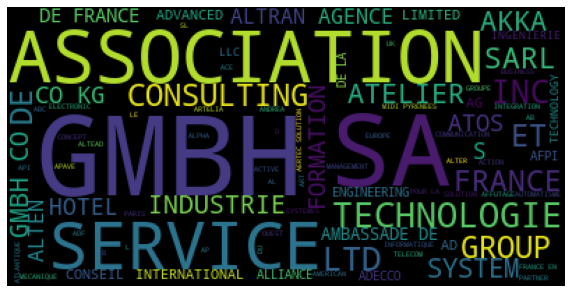

In [26]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_1)
plt.axis('off')
plt.show()

#### The others

Create wordcloud object

In [27]:
other = " "
for i in failed_list :
    other += " "+i
wordcloud = WordCloud().generate(other)

visualize using plt

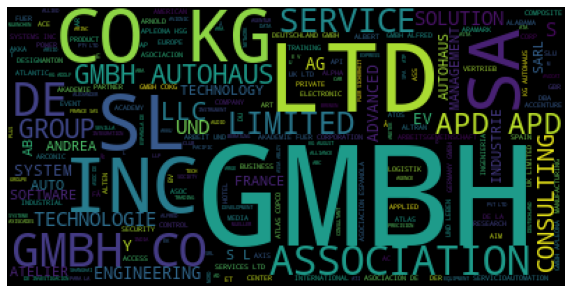

In [28]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Dict of sirens and names

#### Create this dictionnary

In [29]:
dict_sirens = dict()### dict of sirens (keys) and the companies having these sirens (values).

### initialize the dict with empty lists
for i in list_siren_companies :
    dict_sirens[i[1]] = []

### fil these empty lists
for i in list_siren_companies :
    dict_sirens[i[1]].append(i[0])



#### save this dict

In [30]:
np.save("dataset/dict_sirens.npy", dict_sirens)

### Classification of siren-less companies, Top2Vec

We use top2Vec, which is a Topic Modeling technique that clusters the documents in an unsupervised manner. [Top2Vec GitHub](https://github.com/ddangelov/Top2Vec)

#### Model Creation

first we import the failed list

In [31]:
import numpy as np
failed_list = np.load('dataset/failed_list.npy', allow_pickle=True)

In [32]:
from utils import unsupervised_class

classifier = unsupervised_class( failed_list, failed_list, "deep-learn", 6 )


2022-10-18 15:54:21,691 - top2vec - INFO - Pre-processing documents for training
2022-10-18 15:54:21,793 - top2vec - INFO - Creating joint document/word embedding
2022-10-18 15:54:42,143 - top2vec - INFO - Creating lower dimension embedding of documents
2022-10-18 15:54:52,206 - top2vec - INFO - Finding dense areas of documents
2022-10-18 15:54:52,331 - top2vec - INFO - Finding topics


In [33]:
len(failed_list)

3186

In [34]:
classifier.get_num_topics()

2

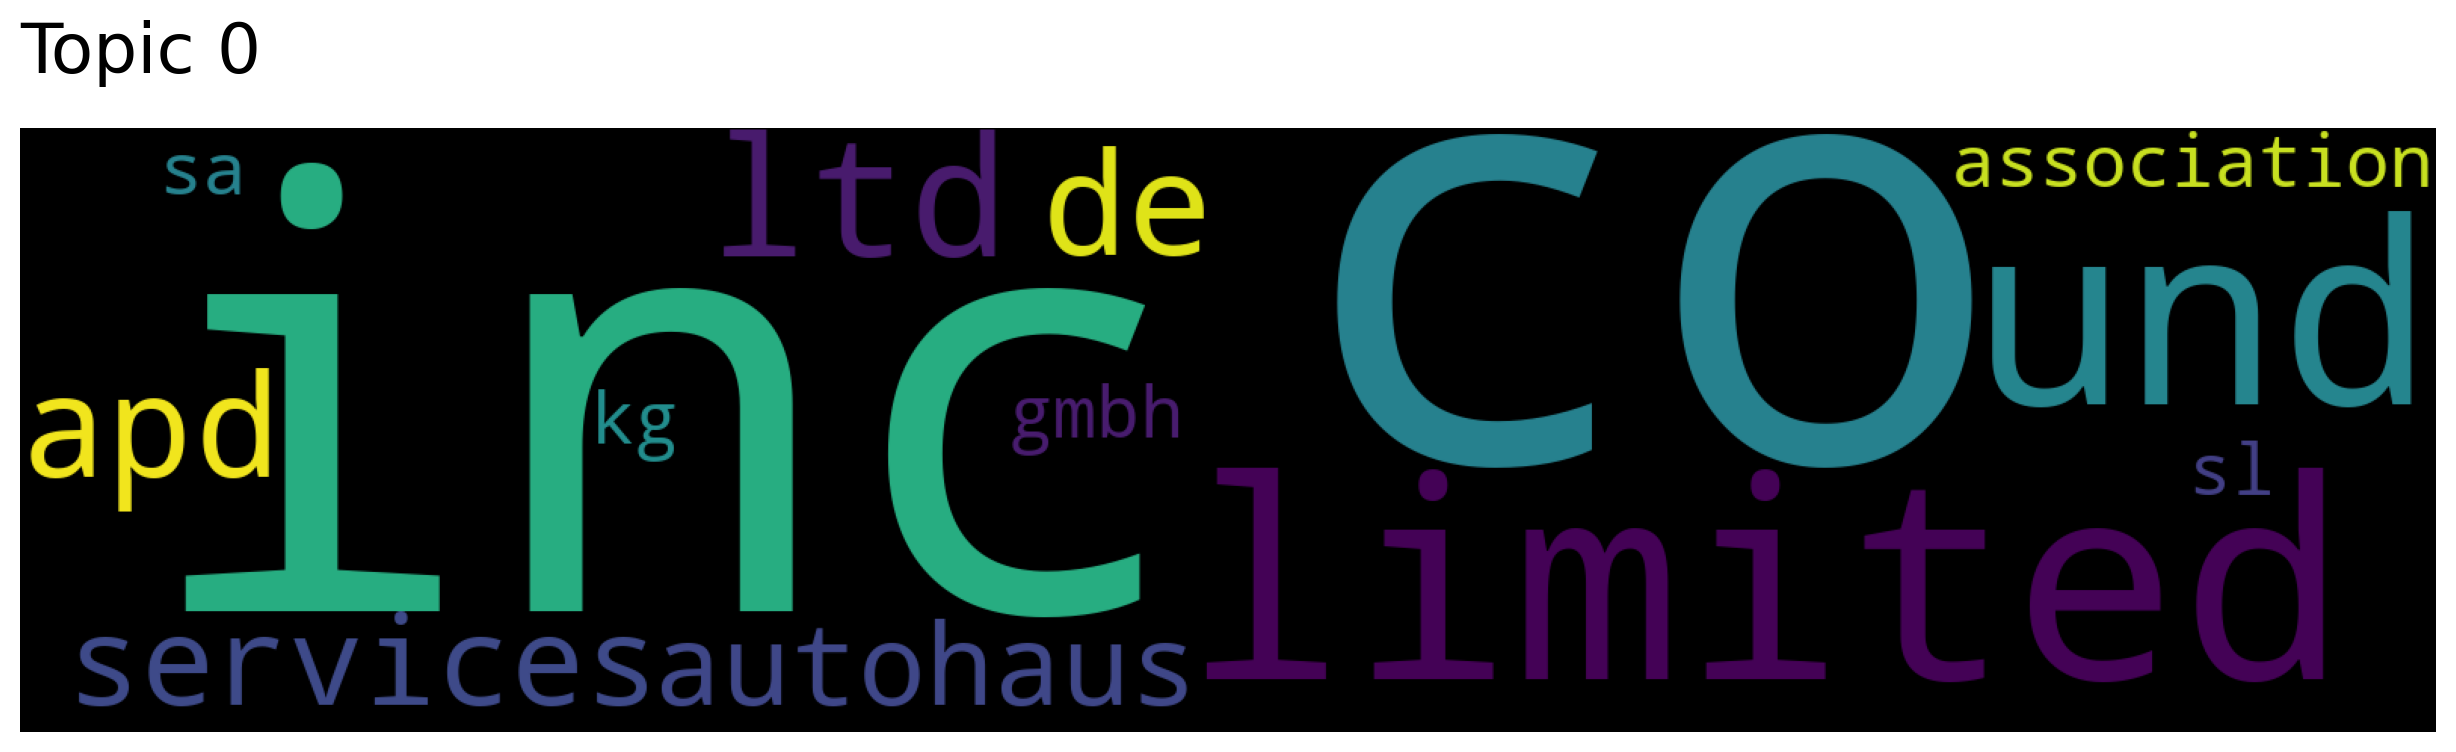

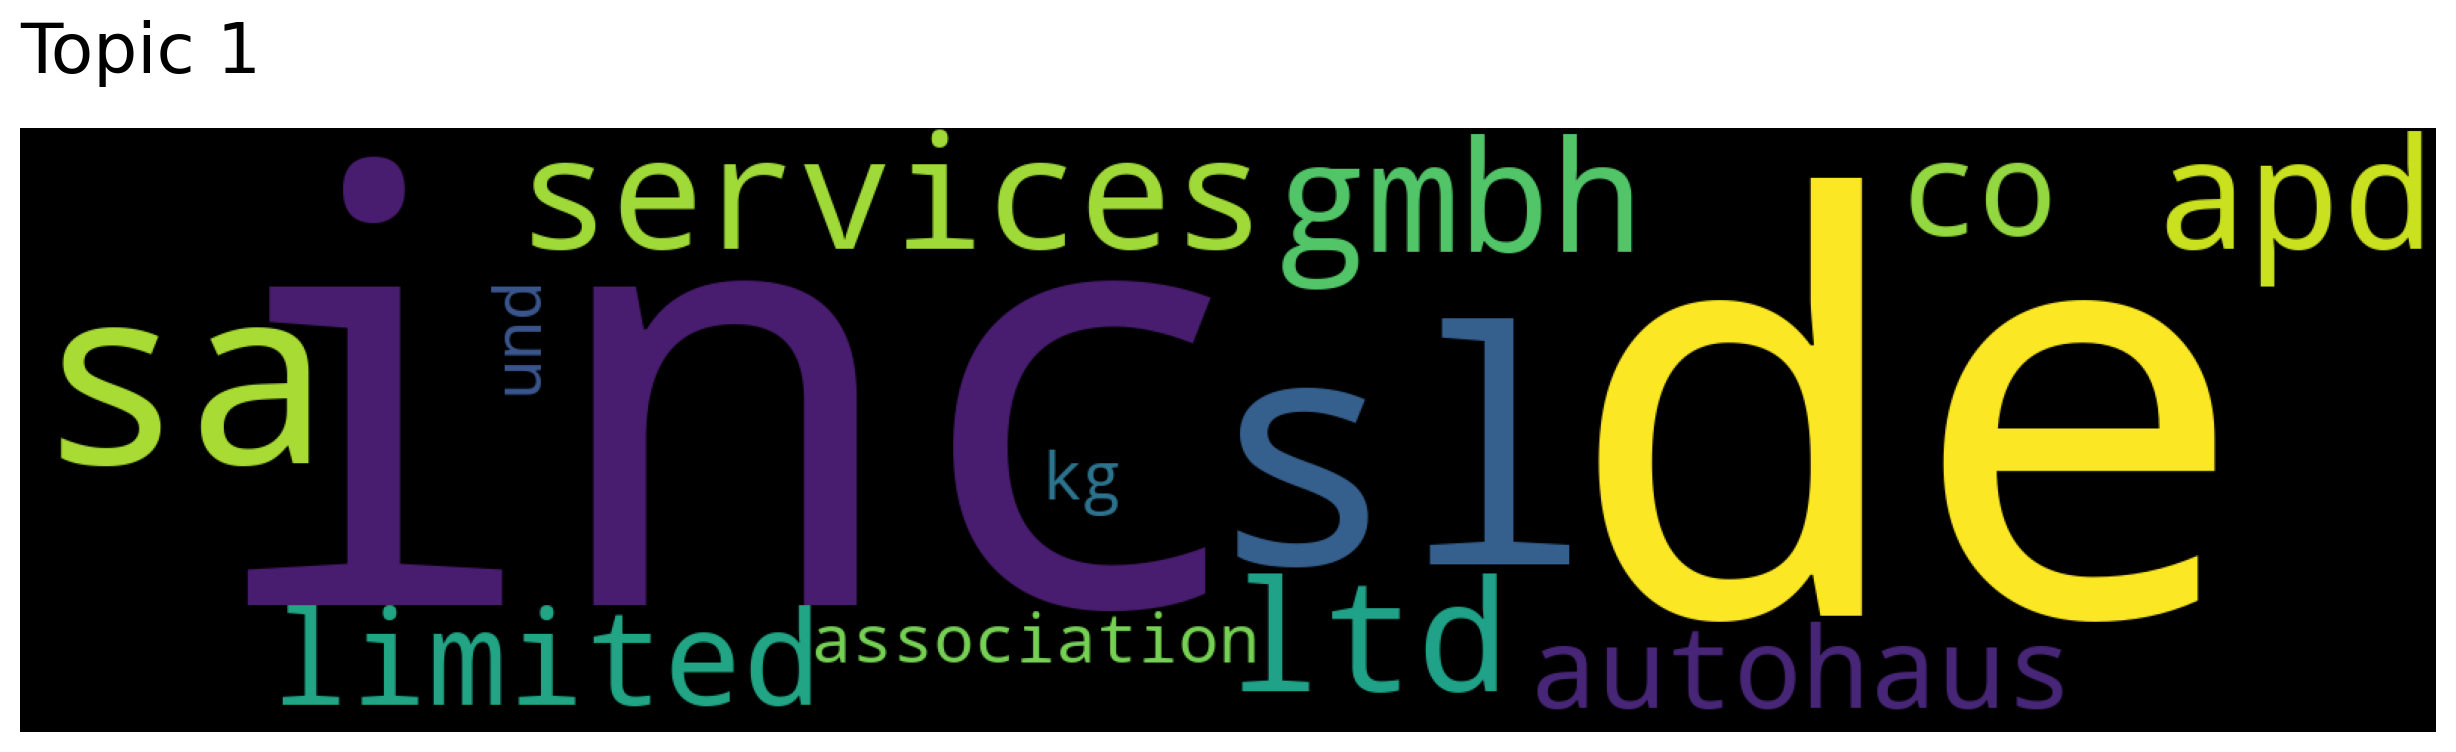

In [35]:
topic_sizes, topic_nums = classifier.get_topic_sizes()
for topic in topic_nums:
    classifier.generate_topic_wordcloud(topic)

### Classification of siren-less companies, tf-idf

we use the tf-idf metric to compute similarities between companies' names [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf)

#### Generate the result dict 

This dict has a company name as a key and the values are constituted of companies similar to the key (including it self)

In [45]:
from utils import tfidf_classification

res_dict = tfidf_classification(failed_list)

detecting similar words       :  81%|████████  | 3186/3930 [00:00<00:00, 26895.55it/s]


here are examples of clusters containing multiple companies' names

In [37]:
for p in res_dict.values() : 
    if len(p) > 3 :
        print(p)
            

['ACCENTURE S.L.', 'ACCENTURE', 'ACCENTURE GMBH', 'ACCENTURE SL']
['AERTEC SOLUTIONS GMBH', 'AERTEC SOLUTIONS, S.L.', 'AERTEC SOLUTIONS S.L.', 'AERTEC SOLUTIONS LTD']
['ALAVA INGENIEROS, S.A.', 'ALAVA INGENIEROS S.A.', 'ALAVA INGENIEROS, SA', 'ALAVA INGENIEROS SA']
['ALTRAN INNOVACION S.L.U.', 'ALTRAN INNOVACION S.L.', 'ALTRAN INNOVACION SL', 'ALTRAN INNOVACION SLU']
['ARAMARK', 'ARAMARK GmbH', 'ARAMARK GMBH', 'ARAMARK LIMITED']


### Chosen clustering for siren-less companies

We can see that Top2Vec yields only 10 categories and the main reason for that is the vectorization step. Indeed, we need to be ables to unclean the input, else, Top2Vec will delete all the special caracters. 
And, another reason is the sparsity of the matrix. UMAP dimensionality reduction - which is used by top2vec - may not be adapted to highly sparse matrices. 

We proceed with the tfidf clustering.

## Result file


#### CSV file creation

First we load our dict of comapnies with sirens

In [38]:
import numpy as np
import pandas as pd

dict_sirens = np.load('dataset/dict_sirens.npy', allow_pickle=True)[()]


We create and visualize the file

In [39]:
from utils import result_CSV

result_CSV(dict_sirens, res_dict)


detecting similar words       : 100%|██████████| 4700/4700 [00:00<00:00, 1317288.93it/s]


In [40]:
result_csv= pd.read_csv('dataset/result.csv')
result_csv=result_csv[["Company name", "Category"]]

In [41]:
result_csv.head()

,Company name,Category
0,A A Z CONSULTING,1
1,A E PETSCHE,2
2,A MAI INTERNATIONAL,2
3,ANATOLE SERVICE COMPTABILITE,2
4,A ET P - LITHOS,3


## 100,000 names case

Now we investigate the behaviour of our algorithms if we had 100,000 company names instead of 4893. 

### Generate the data

we mulitiply our dataset with 21 to have approximately this number

In [42]:
import pandas as pd
from tqdm import tqdm

excel_frame = pd.read_excel('dataset/Case_study_names_mapping.xlsx')
big_frame = excel_frame
for i in tqdm(range(21)):
    big_frame = pd.concat([big_frame, excel_frame])

big_frame

100%|██████████| 21/21 [00:00<00:00, 1044.36it/s]


,Raw name,Mapped name
0,"""ACCESOS NORMALIZADOS, SL""",NaN
1,"""ALTAIX ELECTRONICA , S.A.L.""",NaN
2,"""ANTALA LOCKS & ACCESORIS, SL""",NaN
3,"""ANTERAL, SL""",NaN
4,"""ARQUIMEA INGENIERIA , S.L.""",NaN
...,...,...
4890,TFN PROPROTÃÂ,NaN
4891,UK AND IRELAND SAP USER GROUP LTD,NaN
4892,VSW VERBAND FUER SICHERHEIT IN DER WIRTSCHAFT,NaN
4893,WILLI EBERLEIN GMBH,NaN


### Save the data

In [43]:
big_frame.to_excel('dataset/big_file.xlsx')

First modify the file bath in the .env file to 'dataset/big_file.xlsx' and trial to big

### Run main.py on these data and wait to 10 hours

# I hope you enjoyed it !